In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,classification_report

from tqdm import tqdm

In [2]:
%%time
DF = pd.read_csv('pulled_data/df13.csv')
DF.head(2)

Wall time: 35.4 s


,Unnamed: 0,lead_id,application_id,borrower_name,proposed_payment_date,actual_payment_date,disbursal_amount,emi_no,dpd,principle_amount,interest_amount,balance,Gender,gender_id,DateOfBirth,cibilScore,has_coborrower,institutes_name,course_name,course_cost,requested_loan_amount,loan_type,bre_status,current_status,current_employment_duration,fk_applicant_type_id,profession,marital_status,annual_income,has_active_loan,current_address_city,current_address_state,current_address_pin,permanent_address_city,permanent_address_state,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,loan_initiated,no_emi_paid,OGL,protection_type,course_id,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,status_name,status,age
0,0,6.0,A180119006,Vijay Uttekar,2019-01-15,2019-01-05,60125.0,12,-10.0,4651.0,349.0,9644.0,NaN,-,NaN,NaN,NaN,Vivo Healthcare Pvt Ltd,Radiology Technician,65000.0,65000.0,NaN,NaN,NaN,4.0,2.0,Salaried,Married,200000.0,0.0,7.0,2.0,411032.0,7.0,2.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.5,Running,14.0,NaN,NaN,9.0,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,1,NaN
1,1,6.0,A180119006,Vijay Uttekar,2019-02-15,2019-02-05,60125.0,13,-10.0,4764.0,235.0,4880.0,NaN,-,NaN,NaN,NaN,Vivo Healthcare Pvt Ltd,Radiology Technician,65000.0,65000.0,NaN,NaN,NaN,4.0,2.0,Salaried,Married,200000.0,0.0,7.0,2.0,411032.0,7.0,2.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.5,Running,14.0,NaN,NaN,9.0,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,1,NaN


In [3]:
DF.shape

(2568711, 57)

In [4]:
df_grouped = DF.groupby('application_id')

In [ ]:
for app_id,ind_df in tqdm(df_grouped):
    default_rows = ind_df[ind_df['status']==0]
    if len(default_rows) > 0:
        default_rows.sort_values(by='emi_no',inplace=True)
        first_Time_idx = default_rows.index[0]
        DF.loc[first_Time_idx,'first_time_default'] = 'yes'

 48%|███████████████████████████████████▎                                      | 82700/173195 [01:03<01:40, 899.84it/s]

In [ ]:
DF['first_time_default'].fillna('no',inplace=True)

In [ ]:
DF.isna().sum()

In [ ]:
DF[(DF['proposed_payment_date'] >= datetime.datetime(2023,9,1))&(DF['proposed_payment_date'] < datetime.datetime(2023,10,1))]

In [8]:
DF['proposed_payment_date'] = pd.to_datetime(DF['proposed_payment_date'])
DF_sep = DF[(DF['proposed_payment_date'] >= datetime.datetime(2023,9,1))&(DF['proposed_payment_date'] < datetime.datetime(2023,10,1))]
DF_sep.shape


(73959, 58)

In [9]:
loan_int = pd.read_csv('loan_status.csv')
DF['loan_initiated'].replace(dict(zip(loan_int['id'],loan_int['status'])),inplace=True)
DF.head(1)

,Unnamed: 0,lead_id,application_id,borrower_name,proposed_payment_date,actual_payment_date,disbursal_amount,emi_no,dpd,principle_amount,interest_amount,balance,Gender,gender_id,DateOfBirth,cibilScore,has_coborrower,institutes_name,course_name,course_cost,requested_loan_amount,loan_type,bre_status,current_status,current_employment_duration,fk_applicant_type_id,profession,marital_status,annual_income,has_active_loan,current_address_city,current_address_state,current_address_pin,permanent_address_city,permanent_address_state,permanent_address_pin,final_disbursal_amount,rate_of_interest,tenure,is_moratorium,product_type,rate,loan_initiated,no_emi_paid,OGL,protection_type,course_id,related_industry,course_duration,course_category,institute_type,industry_name,nach_provider,lender_name,status_name,status,age,first_time_default
0,0,6.0,A180119006,Vijay Uttekar,2019-01-15,2019-01-05,60125.0,12,-10.0,4651.0,349.0,9644.0,NaN,-,NaN,NaN,NaN,Vivo Healthcare Pvt Ltd,Radiology Technician,65000.0,65000.0,NaN,NaN,NaN,4.0,2.0,Salaried,Married,200000.0,0.0,7.0,2.0,411032.0,7.0,2.0,411032.0,65000.0,7.69,14.0,NaN,3.0,7.5,Running,14.0,NaN,NaN,9.0,18.0,12.0,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,1,NaN,no


In [10]:
DF = DF[['application_id','borrower_name','proposed_payment_date','course_cost','requested_loan_amount','disbursal_amount','final_disbursal_amount','balance','principle_amount',\
 'interest_amount','emi_no','tenure','course_duration','no_emi_paid','gender_id','age','cibilScore','has_coborrower',\
 'loan_type','bre_status','current_employment_duration','profession','marital_status','annual_income','has_active_loan',\
 'current_address_pin','permanent_address_pin','rate_of_interest','rate','OGL','protection_type','course_category',\
 'institute_type','industry_name','nach_provider','lender_name','status_name','loan_initiated','dpd','first_time_default','status']]

In [11]:
DF

,application_id,borrower_name,proposed_payment_date,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,balance,principle_amount,interest_amount,emi_no,tenure,course_duration,no_emi_paid,gender_id,age,cibilScore,has_coborrower,loan_type,bre_status,current_employment_duration,profession,marital_status,annual_income,has_active_loan,current_address_pin,permanent_address_pin,rate_of_interest,rate,OGL,protection_type,course_category,institute_type,industry_name,nach_provider,lender_name,status_name,loan_initiated,dpd,first_time_default,status
0,A180119006,Vijay Uttekar,2019-01-15,65000.0,65000.0,60125.0,65000.0,9644.0,4651.0,349.0,12,14.0,12.0,14.0,-,NaN,NaN,NaN,NaN,NaN,4.0,Salaried,Married,200000.0,0.0,411032.0,411032.0,7.69,7.50000,NaN,NaN,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,Running,-10.0,no,1
1,A180119006,Vijay Uttekar,2019-02-15,65000.0,65000.0,60125.0,65000.0,4880.0,4764.0,235.0,13,14.0,12.0,14.0,-,NaN,NaN,NaN,NaN,NaN,4.0,Salaried,Married,200000.0,0.0,411032.0,411032.0,7.69,7.50000,NaN,NaN,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,Running,-10.0,no,1
2,A180119006,Vijay Uttekar,2019-03-15,65000.0,65000.0,60125.0,65000.0,0.0,4880.0,119.0,14,14.0,12.0,14.0,-,NaN,NaN,NaN,NaN,NaN,4.0,Salaried,Married,200000.0,0.0,411032.0,411032.0,7.69,7.50000,NaN,NaN,White Collar Personnal,Vocational,HEALTHCARE,physical,Eduvanz Financing Pvt. Ltd.,NaN,Running,-10.0,no,1
3,A180118002,Aditya Satyamoorthy,2019-01-05,500000.0,450000.0,450000.0,450000.0,332821.0,10096.0,8423.0,12,36.0,12.0,36.0,-,NaN,NaN,NaN,NaN,NaN,NaN,Student,Single,NaN,0.0,401107.0,401107.0,16.05,NaN,NaN,NaN,White Collar Personnal,Vocational,ANALYTICS,physical,Eduvanz Financing Pvt. Ltd.,Agreement Pending,Running,0.0,no,1
4,A180118002,Aditya Satyamoorthy,2019-02-05,500000.0,450000.0,450000.0,450000.0,322476.0,10344.0,8175.0,13,36.0,12.0,36.0,-,NaN,NaN,NaN,NaN,NaN,NaN,Student,Single,NaN,0.0,401107.0,401107.0,16.05,NaN,NaN,NaN,White Collar Personnal,Vocational,ANALYTICS,physical,Eduvanz Financing Pvt. Ltd.,Agreement Pending,Running,0.0,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568706,A230909462,Sanjay Kobra,2024-01-05,120000.0,25490.0,23460.0,25490.0,10752.0,2548.0,285.0,5,9.0,12.0,1.0,Male,34.0,00746,0.0,Certification Loan,NaN,4.0,Salaried,Married,1050000.0,0.0,752054.0,752054.0,0.00,25.69994,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,NaN,No Loan,NaN,no,0
2568707,A230909462,Sanjay Kobra,2024-02-05,120000.0,25490.0,23460.0,25490.0,8150.0,2602.0,231.0,6,9.0,12.0,1.0,Male,34.0,00746,0.0,Certification Loan,NaN,4.0,Salaried,Married,1050000.0,0.0,752054.0,752054.0,0.00,25.69994,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,NaN,No Loan,NaN,no,0
2568708,A230909462,Sanjay Kobra,2024-03-05,120000.0,25490.0,23460.0,25490.0,5492.0,2658.0,175.0,7,9.0,12.0,1.0,Male,34.0,00746,0.0,Certification Loan,NaN,4.0,Salaried,Married,1050000.0,0.0,752054.0,752054.0,0.00,25.69994,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,NaN,No Loan,NaN,no,0
2568709,A230909462,Sanjay Kobra,2024-04-05,120000.0,25490.0,23460.0,25490.0,2777.0,2715.0,118.0,8,9.0,12.0,1.0,Male,34.0,00746,0.0,Certification Loan,NaN,4.0,Salaried,Married,1050000.0,0.0,752054.0,752054.0,0.00,25.69994,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,razorpay,ABFL,NaN,No Loan,NaN,no,0


In [12]:
DF.isna().sum()

application_id                     486
borrower_name                     1065
proposed_payment_date                0
course_cost                        486
requested_loan_amount              606
disbursal_amount                    80
final_disbursal_amount             237
balance                              0
principle_amount                     0
interest_amount                      0
emi_no                               0
tenure                             237
course_duration                    486
no_emi_paid                        237
gender_id                          495
age                               4969
cibilScore                        3387
has_coborrower                    3387
loan_type                        86555
bre_status                     2568711
current_employment_duration       3235
profession                         589
marital_status                    1118
annual_income                     2993
has_active_loan                    486
current_address_pin      

In [13]:
df = DF.copy()
df['OGL'].fillna('-',inplace=True)
df1 = df[['proposed_payment_date','course_cost','requested_loan_amount','disbursal_amount','final_disbursal_amount','tenure','balance','principle_amount','interest_amount','no_emi_paid','gender_id','age','cibilScore','has_coborrower','loan_type','current_employment_duration','profession','marital_status','annual_income','current_address_pin','permanent_address_pin','rate_of_interest','permanent_address_pin','OGL','protection_type','course_category','institute_type','industry_name','emi_no','status']]
df1.shape

(2568711, 30)

In [14]:
df1.isna().sum()

proposed_payment_date               0
course_cost                       486
requested_loan_amount             606
disbursal_amount                   80
final_disbursal_amount            237
tenure                            237
balance                             0
principle_amount                    0
interest_amount                     0
no_emi_paid                       237
gender_id                         495
age                              4969
cibilScore                       3387
has_coborrower                   3387
loan_type                       86555
current_employment_duration      3235
profession                        589
marital_status                   1118
annual_income                    2993
current_address_pin               876
permanent_address_pin            1439
rate_of_interest                  237
permanent_address_pin            1439
OGL                                 0
protection_type                360491
course_category                   486
institute_ty

In [15]:
df1['no_emi_paid_prev'] = df1['no_emi_paid']
df1.loc[df1['emi_no'] <= df1['no_emi_paid'],'no_emi_paid_prev'] = df1['emi_no']-1

In [16]:
df1.isna().sum()

proposed_payment_date               0
course_cost                       486
requested_loan_amount             606
disbursal_amount                   80
final_disbursal_amount            237
tenure                            237
balance                             0
principle_amount                    0
interest_amount                     0
no_emi_paid                       237
gender_id                         495
age                              4969
cibilScore                       3387
has_coborrower                   3387
loan_type                       86555
current_employment_duration      3235
profession                        589
marital_status                   1118
annual_income                    2993
current_address_pin               876
permanent_address_pin            1439
rate_of_interest                  237
permanent_address_pin            1439
OGL                                 0
protection_type                360491
course_category                   486
institute_ty

In [17]:
df1.dropna(axis=0,inplace=True)
# df1.reset_index(inplace=True,drop=True)
df1.shape

(2193672, 31)

In [18]:
df1.loc[df1['cibilScore'] == '000-1','cibilScore'] = '0'
df1.loc[df1['cibilScore'].isna(),'cibilScore'] = 0
df1['cibilScore'] = df1['cibilScore'].astype(int)

In [19]:
df1

,proposed_payment_date,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,tenure,balance,principle_amount,interest_amount,no_emi_paid,gender_id,age,cibilScore,has_coborrower,loan_type,current_employment_duration,profession,marital_status,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,permanent_address_pin,OGL,protection_type,course_category,institute_type,industry_name,emi_no,status,no_emi_paid_prev
87381,2020-02-05,383500.0,365000.0,350400.0,365000.0,48.0,345393.0,5007.0,5336.0,23.0,Female,29.0,694,0.0,Certification Loan,4.0,Salaried,Single,385344.0,600078.0,600078.0,9.0,600078.0,No,PRO-RATA,White Collar Personnal,Vocational,ENGINEERING SERVICES,1,1,0.0
87382,2020-03-05,383500.0,365000.0,350400.0,365000.0,48.0,340310.0,5083.0,5260.0,23.0,Female,29.0,694,0.0,Certification Loan,4.0,Salaried,Single,385344.0,600078.0,600078.0,9.0,600078.0,No,PRO-RATA,White Collar Personnal,Vocational,ENGINEERING SERVICES,2,1,1.0
87383,2020-04-05,383500.0,365000.0,350400.0,365000.0,48.0,335149.0,5161.0,5182.0,23.0,Female,29.0,694,0.0,Certification Loan,4.0,Salaried,Single,385344.0,600078.0,600078.0,9.0,600078.0,No,PRO-RATA,White Collar Personnal,Vocational,ENGINEERING SERVICES,3,1,2.0
87384,2020-05-05,383500.0,365000.0,350400.0,365000.0,48.0,329910.0,5239.0,5104.0,23.0,Female,29.0,694,0.0,Certification Loan,4.0,Salaried,Single,385344.0,600078.0,600078.0,9.0,600078.0,No,PRO-RATA,White Collar Personnal,Vocational,ENGINEERING SERVICES,4,1,3.0
87385,2020-06-05,383500.0,365000.0,350400.0,365000.0,48.0,324591.0,5319.0,5024.0,23.0,Female,29.0,694,0.0,Certification Loan,4.0,Salaried,Single,385344.0,600078.0,600078.0,9.0,600078.0,No,PRO-RATA,White Collar Personnal,Vocational,ENGINEERING SERVICES,5,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568706,2024-01-05,120000.0,25490.0,23460.0,25490.0,9.0,10752.0,2548.0,285.0,1.0,Male,34.0,746,0.0,Certification Loan,4.0,Salaried,Married,1050000.0,752054.0,752054.0,0.0,752054.0,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,5,0,1.0
2568707,2024-02-05,120000.0,25490.0,23460.0,25490.0,9.0,8150.0,2602.0,231.0,1.0,Male,34.0,746,0.0,Certification Loan,4.0,Salaried,Married,1050000.0,752054.0,752054.0,0.0,752054.0,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,6,0,1.0
2568708,2024-03-05,120000.0,25490.0,23460.0,25490.0,9.0,5492.0,2658.0,175.0,1.0,Male,34.0,746,0.0,Certification Loan,4.0,Salaried,Married,1050000.0,752054.0,752054.0,0.0,752054.0,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,7,0,1.0
2568709,2024-04-05,120000.0,25490.0,23460.0,25490.0,9.0,2777.0,2715.0,118.0,1.0,Male,34.0,746,0.0,Certification Loan,4.0,Salaried,Married,1050000.0,752054.0,752054.0,0.0,752054.0,No,NO PROTECTION,White Collar Personnal,Vocational,EDUCATION & TRAINING,8,0,1.0


In [79]:
df_till_sep = df1[df1['proposed_payment_date'] < datetime.datetime(2023,11,1)]

In [80]:
categorical_columns = list(set(df_till_sep.columns) - set(df_till_sep._get_numeric_data().columns))
# categorical_columns.remove('proposed_payment_date')
numerical_columns = df_till_sep._get_numeric_data().columns.tolist()
cat_cal_fill = ['-' for i in range(0,len(numerical_columns) - len(categorical_columns))]
categorical_columns.extend(cat_cal_fill)
df_num_cat = pd.DataFrame({'numerical_columns':numerical_columns,'categorical_columns':categorical_columns})
display(df_num_cat)
categorical_columns = list(set(categorical_columns))
categorical_columns.remove('-')


,numerical_columns,categorical_columns
0,course_cost,profession
1,requested_loan_amount,proposed_payment_date
2,disbursal_amount,protection_type
3,final_disbursal_amount,institute_type
4,tenure,marital_status
5,balance,course_category
6,principle_amount,loan_type
7,interest_amount,OGL
8,no_emi_paid,gender_id
9,age,industry_name


In [81]:
final_cat_col_ls = []
value_counts_ls = categorical_columns
to_remove_ls = ['proposed_payment_date','actual_payment_date']
for each_value_counts_ls in value_counts_ls[:] :
    if each_value_counts_ls not in to_remove_ls:
        df_till_sep[each_value_counts_ls] = df_till_sep[each_value_counts_ls].str.lower()
    final_cat_col_ls.append(each_value_counts_ls)
        

In [82]:
independent_columns = []
independent_columns.extend(numerical_columns)
independent_columns.extend(final_cat_col_ls)

In [83]:
df_till_sep

,proposed_payment_date,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,tenure,balance,principle_amount,interest_amount,no_emi_paid,gender_id,age,cibilScore,has_coborrower,loan_type,current_employment_duration,profession,marital_status,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,permanent_address_pin,OGL,protection_type,course_category,institute_type,industry_name,emi_no,status,no_emi_paid_prev
87381,2020-02-05,383500.0,365000.0,350400.0,365000.0,48.0,345393.0,5007.0,5336.0,23.0,female,29.0,694,0.0,certification loan,4.0,salaried,single,385344.0,600078.0,600078.0,9.00,600078.0,no,pro-rata,white collar personnal,vocational,engineering services,1,1,0.0
87382,2020-03-05,383500.0,365000.0,350400.0,365000.0,48.0,340310.0,5083.0,5260.0,23.0,female,29.0,694,0.0,certification loan,4.0,salaried,single,385344.0,600078.0,600078.0,9.00,600078.0,no,pro-rata,white collar personnal,vocational,engineering services,2,1,1.0
87383,2020-04-05,383500.0,365000.0,350400.0,365000.0,48.0,335149.0,5161.0,5182.0,23.0,female,29.0,694,0.0,certification loan,4.0,salaried,single,385344.0,600078.0,600078.0,9.00,600078.0,no,pro-rata,white collar personnal,vocational,engineering services,3,1,2.0
87384,2020-05-05,383500.0,365000.0,350400.0,365000.0,48.0,329910.0,5239.0,5104.0,23.0,female,29.0,694,0.0,certification loan,4.0,salaried,single,385344.0,600078.0,600078.0,9.00,600078.0,no,pro-rata,white collar personnal,vocational,engineering services,4,1,3.0
87385,2020-06-05,383500.0,365000.0,350400.0,365000.0,48.0,324591.0,5319.0,5024.0,23.0,female,29.0,694,0.0,certification loan,4.0,salaried,single,385344.0,600078.0,600078.0,9.00,600078.0,no,pro-rata,white collar personnal,vocational,engineering services,5,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568666,2023-09-10,120000.0,42990.0,38932.0,42990.0,12.0,35349.0,3583.0,0.0,1.0,female,21.0,772,0.0,certification loan,4.0,salaried,single,450000.0,201310.0,201310.0,0.00,201310.0,no,principal protection till loan tenure,white collar personnal,vocational,education & training,1,1,0.0
2568667,2023-10-05,120000.0,42990.0,38932.0,42990.0,12.0,32424.0,2925.0,658.0,1.0,female,21.0,772,0.0,certification loan,4.0,salaried,single,450000.0,201310.0,201310.0,0.00,201310.0,no,principal protection till loan tenure,white collar personnal,vocational,education & training,2,0,1.0
2568678,2023-10-05,488000.0,132000.0,130442.0,132000.0,24.0,126011.0,4431.0,2255.0,0.0,male,39.0,809,0.0,certification loan,3.0,salaried,single,1990440.0,560067.0,560067.0,10.78,560067.0,no,no protection,white collar personnal,vocational,engineering services,1,0,0.0
2568702,2023-09-10,120000.0,25490.0,23460.0,25490.0,9.0,20627.0,2833.0,0.0,1.0,male,34.0,746,0.0,certification loan,4.0,salaried,married,1050000.0,752054.0,752054.0,0.00,752054.0,no,no protection,white collar personnal,vocational,education & training,1,1,0.0


In [84]:
df3 = df_till_sep[independent_columns]
df3 = df3.loc[:, ~df3.columns.duplicated()]

In [85]:
to_encode_col = final_cat_col_ls
to_remove_ls = ['proposed_payment_date','actual_payment_date']
for each_col in to_encode_col:
    if each_col not in to_remove_ls:
        print(each_col)
        df3[f'{each_col}'] = ord_enc.fit_transform(df3[[each_col]])

profession
protection_type
institute_type
marital_status
course_category
loan_type
OGL
gender_id
industry_name


In [86]:
df3

,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,tenure,balance,principle_amount,interest_amount,no_emi_paid,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,emi_no,status,no_emi_paid_prev,profession,proposed_payment_date,protection_type,institute_type,marital_status,course_category,loan_type,OGL,gender_id,industry_name
87381,383500.0,365000.0,350400.0,365000.0,48.0,345393.0,5007.0,5336.0,23.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,1,1,0.0,0.0,2020-02-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
87382,383500.0,365000.0,350400.0,365000.0,48.0,340310.0,5083.0,5260.0,23.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,2,1,1.0,0.0,2020-03-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
87383,383500.0,365000.0,350400.0,365000.0,48.0,335149.0,5161.0,5182.0,23.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,3,1,2.0,0.0,2020-04-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
87384,383500.0,365000.0,350400.0,365000.0,48.0,329910.0,5239.0,5104.0,23.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,4,1,3.0,0.0,2020-05-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
87385,383500.0,365000.0,350400.0,365000.0,48.0,324591.0,5319.0,5024.0,23.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,5,1,4.0,0.0,2020-06-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568666,120000.0,42990.0,38932.0,42990.0,12.0,35349.0,3583.0,0.0,1.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,1,1,0.0,0.0,2023-09-10,3.0,5.0,1.0,1.0,0.0,1.0,1.0,10.0
2568667,120000.0,42990.0,38932.0,42990.0,12.0,32424.0,2925.0,658.0,1.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,2,0,1.0,0.0,2023-10-05,3.0,5.0,1.0,1.0,0.0,1.0,1.0,10.0
2568678,488000.0,132000.0,130442.0,132000.0,24.0,126011.0,4431.0,2255.0,0.0,39.0,809,0.0,3.0,1990440.0,560067.0,560067.0,10.78,1,0,0.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,1.0,2.0,12.0
2568702,120000.0,25490.0,23460.0,25490.0,9.0,20627.0,2833.0,0.0,1.0,34.0,746,0.0,4.0,1050000.0,752054.0,752054.0,0.00,1,1,0.0,0.0,2023-09-10,0.0,5.0,0.0,1.0,0.0,1.0,2.0,10.0


In [87]:
df3.drop('no_emi_paid',axis=1,inplace=True)

In [88]:
df_till_may = df3[df3['proposed_payment_date']<datetime.datetime(2023,9,1)]
df_2023_sep = df3[(df3['proposed_payment_date']>=datetime.datetime(2023,9,1))&(df3['proposed_payment_date']<datetime.datetime(2023,10,1))]
df_2023_oct = df3[(df3['proposed_payment_date']>=datetime.datetime(2023,10,1))&(df3['proposed_payment_date']<datetime.datetime(2023,11,1))]

In [89]:
df_2023_oct

,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,tenure,balance,principle_amount,interest_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,emi_no,status,no_emi_paid_prev,profession,proposed_payment_date,protection_type,institute_type,marital_status,course_category,loan_type,OGL,gender_id,industry_name
87425,383500.0,365000.0,350400.0,365000.0,48.0,30139.0,9735.0,608.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,45,0,23.0,0.0,2023-10-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0
88460,442500.0,350000.0,350000.0,350000.0,51.0,58258.0,9219.0,990.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.00,44,0,20.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,0.0,2.0,1.0
99927,725700.0,725700.0,725700.0,725700.0,60.0,251732.0,14058.0,3482.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.00,44,0,23.0,0.0,2023-10-05,0.0,5.0,0.0,1.0,6.0,0.0,2.0,22.0
101895,450000.0,400000.0,400000.0,400000.0,48.0,55883.0,10690.0,977.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.00,44,0,43.0,0.0,2023-10-05,4.0,5.0,1.0,1.0,0.0,0.0,2.0,21.0
130474,450000.0,250000.0,250000.0,250000.0,48.0,54694.0,6395.0,897.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.00,40,0,39.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,1.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568582,345000.0,331000.0,269484.0,331000.0,24.0,260314.0,9170.0,4622.0,27.0,785,0.0,4.0,700000.0,534460.0,534460.0,0.00,1,0,0.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,1.0,1.0,10.0
2568606,434000.0,294000.0,294000.0,294000.0,60.0,290815.0,3185.0,4043.0,26.0,761,0.0,4.0,1009716.0,444706.0,444706.0,9.50,1,0,0.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,1.0,2.0,10.0
2568667,120000.0,42990.0,38932.0,42990.0,12.0,32424.0,2925.0,658.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,2,0,1.0,0.0,2023-10-05,3.0,5.0,1.0,1.0,0.0,1.0,1.0,10.0
2568678,488000.0,132000.0,130442.0,132000.0,24.0,126011.0,4431.0,2255.0,39.0,809,0.0,3.0,1990440.0,560067.0,560067.0,10.78,1,0,0.0,0.0,2023-10-05,0.0,5.0,1.0,1.0,0.0,1.0,2.0,12.0


In [90]:
df_till_may.head(1)

,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,tenure,balance,principle_amount,interest_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,emi_no,status,no_emi_paid_prev,profession,proposed_payment_date,protection_type,institute_type,marital_status,course_category,loan_type,OGL,gender_id,industry_name
87381,383500.0,365000.0,350400.0,365000.0,48.0,345393.0,5007.0,5336.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1,1,0.0,0.0,2020-02-05,4.0,5.0,1.0,1.0,0.0,1.0,1.0,12.0


In [91]:
# filtered_columns = ['emi_no','tenure','no_emi_paid','course_cost', 'requested_loan_amount', 'disbursal_amount','final_disbursal_amount', 'age', 'cibilScore', 'has_coborrower','current_employment_duration', 'annual_income', 'current_address_pin','permanent_address_pin', 'rate_of_interest', 'marital_status','loan_type', 'industry_name', 'gender_id', 'profession','course_category', 'protection_type', 'institute_type', 'bre_status','OGL','status']
filtered_columns = ['emi_no','tenure','course_cost', 'requested_loan_amount', 'disbursal_amount','final_disbursal_amount', 'age', 'cibilScore', 'has_coborrower','current_employment_duration', 'annual_income', 'current_address_pin','permanent_address_pin', 'rate_of_interest', 'marital_status','loan_type', 'industry_name', 'gender_id', 'profession','course_category', 'protection_type', 'institute_type','OGL','no_emi_paid_prev','status']
df_till_may = df_till_may[filtered_columns]
df_2023_sep = df_2023_sep[filtered_columns]
df_2023_oct = df_2023_oct[filtered_columns]

In [92]:
print(df_till_may['status'].value_counts())
print(df_2023_sep['status'].value_counts())
print(df_2023_oct['status'].value_counts())

1    1170635
0     165755
Name: status, dtype: int64
1    53369
0    17440
Name: status, dtype: int64
0    68040
1     1108
Name: status, dtype: int64


In [93]:
df_till_may = df_till_may.drop_duplicates(keep='last')
df_2023_sep = df_2023_sep.drop_duplicates(keep='last')
df_2023_oct = df_2023_oct.drop_duplicates(keep='last')

In [94]:
print(df_till_may['status'].value_counts())
print(df_2023_sep['status'].value_counts())
print(df_2023_oct['status'].value_counts())

1    1169092
0     165428
Name: status, dtype: int64
1    53345
0    17435
Name: status, dtype: int64
0    68008
1     1108
Name: status, dtype: int64


In [95]:
df_till_may.head(2)

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status
87381,1,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,0.0,1
87382,2,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,1.0,1


In [96]:
df_status_prediction_X = df_till_may.drop('status',axis=1)
df_status_prediction_y = df_till_may['status']

In [97]:
df_status_prediction_y.value_counts()

1    1169092
0     165428
Name: status, dtype: int64

In [38]:
%%time
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)

x_smote, y_smote = smote.fit_resample(df_status_prediction_X, df_status_prediction_y)


Wall time: 10min 12s


In [39]:
x_smote.shape

(2338184, 24)

In [40]:
y_smote.value_counts()

1    1169092
0    1169092
Name: status, dtype: int64

In [41]:
len(y_smote)

2338184

In [42]:
X_train, X_test,y_train, y_test = train_test_split(x_smote, y_smote,test_size=0.2,random_state=40,stratify=y_smote)

In [48]:
# %%time
# import xgboost as xgb

# xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=70, objective="binary:logistic", min_child_weight=10,learning_rate=0.5)

# xgb_model.fit(X_train, y_train)

Wall time: 2h 21min 26s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=70, max_leaves=0, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [49]:
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, xgb_pred_test)
print("XGBoost model accuracy (in %):", accuracy * 100)

XGBoost model accuracy (in %): 99.54558771012559



********  Trained Metrics  ********


Predict,0,1,All
Actual,,,
0,279980,280996,560976
1,468132,467142,935274
All,748112,748138,1496250



Accuracy : 100.0 %
Precision : 100.0 %
Recall : 100.0 %
f1 score : 100.0 % 

********  Test Metrics  ********


Predict,0,1,All
Actual,,,
0,7561,7412,14973
1,39615,39192,78807
All,47176,46604,93780



Accuracy : 100.0 %
Precision : 100.0 %
Recall : 99.0 %
f1 score : 100.0 % 


,Feature,Importance
23,no_emi_paid_prev,0.356468
0,emi_no,0.278971
21,institute_type,0.124772
1,tenure,0.035591
19,course_category,0.027717
20,protection_type,0.017806
16,industry_name,0.016506
15,loan_type,0.013242
2,course_cost,0.011903
13,rate_of_interest,0.011870


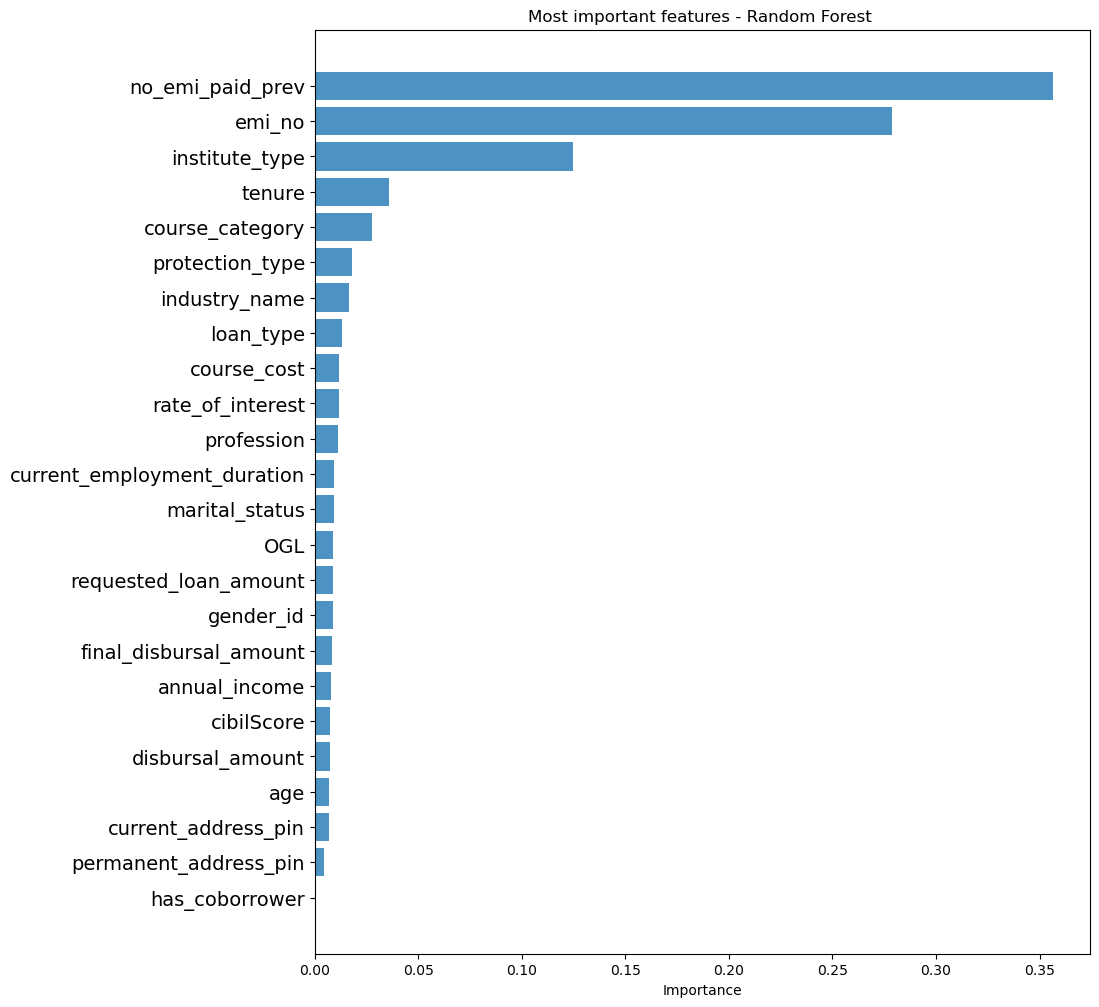

In [50]:
print('\n********  Trained Metrics  ********')

display(pd.crosstab(pd.Series(y_train, name = 'Actual'), pd.Series(xgb_pred_train, name = 'Predict'), margins = True))

print(f'\nAccuracy : {round(accuracy_score(y_train, xgb_pred_train)*100,0)} %')
print(f'Precision : {round(precision_score(y_train, xgb_pred_train)*100,0)} %')
print(f'Recall : {round(recall_score(y_train, xgb_pred_train)*100,0)} %')
print(f'f1 score : {round(f1_score(y_train, xgb_pred_train)*100,0)} % ')

print('\n********  Test Metrics  ********')
display(pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(xgb_pred_test, name = 'Predict'), margins = True))
print(f'\nAccuracy : {round(accuracy_score(y_test, xgb_pred_test)*100,0)} %')
print(f'Precision : {round(precision_score(y_test, xgb_pred_test)*100,0)} %')
print(f'Recall : {round(recall_score(y_test, xgb_pred_test)*100,0)} %')
print(f'f1 score : {round(f1_score(y_test, xgb_pred_test)*100,0)} % ')

feature_names = X_train.columns
feature_imports = xgb_model.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(40, "Importance")
display(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,12))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

In [51]:
print(classification_report(y_train, xgb_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    935273
           1       1.00      1.00      1.00    935274

    accuracy                           1.00   1870547
   macro avg       1.00      1.00      1.00   1870547
weighted avg       1.00      1.00      1.00   1870547



In [52]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    233819
           1       1.00      0.99      1.00    233818

    accuracy                           1.00    467637
   macro avg       1.00      1.00      1.00    467637
weighted avg       1.00      1.00      1.00    467637



In [98]:
from joblib import dump, load

# dump(xgb_model, 'xgb_model_september_prediction.joblib')

load_model = load('xgb_model_september_prediction.joblib')


In [44]:
xgb_pred_train = load_model.predict(X_train)
xgb_pred_test = load_model.predict(X_test)

accuracy = accuracy_score(y_test, xgb_pred_test)
print("XGBoost model accuracy (in %):", accuracy * 100)

XGBoost model accuracy (in %): 99.54558771012559


In [45]:
print(classification_report(y_train, xgb_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    935273
           1       1.00      1.00      1.00    935274

    accuracy                           1.00   1870547
   macro avg       1.00      1.00      1.00   1870547
weighted avg       1.00      1.00      1.00   1870547



In [46]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    233819
           1       1.00      0.99      1.00    233818

    accuracy                           1.00    467637
   macro avg       1.00      1.00      1.00    467637
weighted avg       1.00      1.00      1.00    467637



In [103]:
df_2023_sep_status_prediction_X = df_2023_sep.drop('status',axis=1)

In [104]:
y_pred_2023_sep = load_model.predict(df_2023_sep_status_prediction_X)

In [105]:
print(classification_report(df_2023_sep['status'],y_pred_2023_sep))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     17435
           1       0.89      1.00      0.94     53345

    accuracy                           0.91     70780
   macro avg       0.94      0.81      0.85     70780
weighted avg       0.91      0.91      0.90     70780



In [106]:
september_df = df_2023_sep.copy()

In [107]:
september_df

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status
87424,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0
88459,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0
99926,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0
101894,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1
130473,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568393,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1
2568537,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1
2568558,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1
2568666,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1


In [109]:
september_df['predicted'] = y_pred_2023_sep

In [110]:
september_df

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,predicted
87424,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,0
88459,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,0
99926,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,0
101894,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1,1
130473,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568393,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1
2568537,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1
2568558,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1
2568666,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1


In [ ]:
# df_2023_oct

In [111]:
DF_to_join = DF[['application_id','proposed_payment_date','borrower_name','first_time_default']]

In [112]:
DF_to_join

,application_id,proposed_payment_date,borrower_name,first_time_default
0,A180119006,2019-01-15,Vijay Uttekar,no
1,A180119006,2019-02-15,Vijay Uttekar,no
2,A180119006,2019-03-15,Vijay Uttekar,no
3,A180118002,2019-01-05,Aditya Satyamoorthy,no
4,A180118002,2019-02-05,Aditya Satyamoorthy,no
...,...,...,...,...
2568706,A230909462,2024-01-05,Sanjay Kobra,no
2568707,A230909462,2024-02-05,Sanjay Kobra,no
2568708,A230909462,2024-03-05,Sanjay Kobra,no
2568709,A230909462,2024-04-05,Sanjay Kobra,no


In [113]:
september_df_final = september_df.merge(DF_to_join, left_index = True, right_index=True)

In [114]:
september_df_final

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,predicted,application_id,proposed_payment_date,borrower_name,first_time_default
87424,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,0,A200113181,2023-09-05,divya kummar,no
88459,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,0,A200113061,2023-09-05,Cherla Benher,no
99926,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,0,A200205195,2023-09-05,P Tripathy,no
101894,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1,1,A200210078,2023-09-05,Niyati Jagtap,no
130473,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1,1,A200604180,2023-09-05,Sahana C,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568393,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1,A230909272,2023-09-10,Femin Raheem,no
2568537,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1,A230909257,2023-09-10,Mohammed Maniyar,no
2568558,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1,A230905670,2023-09-10,Chirag Chand,no
2568666,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1,A230910211,2023-09-10,Debopriya Lahiri,no


In [119]:
september_paid_app_ls = september_df_final[september_df_final['predicted']==1]['application_id'].tolist()

In [ ]:
# df_2023_oct

In [130]:
oct_df_final = df_2023_oct.merge(DF_to_join, left_index = True, right_index=True)

In [131]:
oct_df_final

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,application_id,proposed_payment_date,borrower_name,first_time_default
87425,45,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,A200113181,2023-10-05,divya kummar,no
88460,44,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.00,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,A200113061,2023-10-05,Cherla Benher,no
99927,44,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.00,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,A200205195,2023-10-05,P Tripathy,no
101895,44,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.00,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,43.0,0,A200210078,2023-10-05,Niyati Jagtap,yes
130474,40,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,39.0,0,A200604180,2023-10-05,Sahana C,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568582,1,24.0,345000.0,331000.0,269484.0,331000.0,27.0,785,0.0,4.0,700000.0,534460.0,534460.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,0,A230824702,2023-10-05,Vissavajjula Sarmishta,yes
2568606,1,60.0,434000.0,294000.0,294000.0,294000.0,26.0,761,0.0,4.0,1009716.0,444706.0,444706.0,9.50,1.0,0.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0,A230909191,2023-10-05,Shivam Borole,yes
2568667,2,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,1.0,0,A230910211,2023-10-05,Debopriya Lahiri,yes
2568678,1,24.0,488000.0,132000.0,130442.0,132000.0,39.0,809,0.0,3.0,1990440.0,560067.0,560067.0,10.78,1.0,0.0,12.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0,A230910080,2023-10-05,Sunayan Sarkar,yes


In [132]:
oct_df_final.loc[oct_df_final['application_id'].isin(september_paid_app_ls),'no_emi_paid_prev'] = oct_df_final['no_emi_paid_prev']+1
oct_df_final.loc[oct_df_final['application_id'].isin(september_paid_app_ls),'status'] = 1

In [133]:
df_2023_oct.columns

Index(['emi_no', 'tenure', 'course_cost', 'requested_loan_amount',
       'disbursal_amount', 'final_disbursal_amount', 'age', 'cibilScore',
       'has_coborrower', 'current_employment_duration', 'annual_income',
       'current_address_pin', 'permanent_address_pin', 'rate_of_interest',
       'marital_status', 'loan_type', 'industry_name', 'gender_id',
       'profession', 'course_category', 'protection_type', 'institute_type',
       'OGL', 'no_emi_paid_prev', 'status'],
      dtype='object')

In [134]:
oct_df_final = oct_df_final[df_2023_oct.columns.tolist()]

In [135]:
oct_df_final

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status
87425,45,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0
88460,44,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.00,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0
99927,44,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.00,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0
101895,44,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.00,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,44.0,1
130474,40,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,40.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568582,1,24.0,345000.0,331000.0,269484.0,331000.0,27.0,785,0.0,4.0,700000.0,534460.0,534460.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,0
2568606,1,60.0,434000.0,294000.0,294000.0,294000.0,26.0,761,0.0,4.0,1009716.0,444706.0,444706.0,9.50,1.0,0.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0
2568667,2,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,2.0,1
2568678,1,24.0,488000.0,132000.0,130442.0,132000.0,39.0,809,0.0,3.0,1990440.0,560067.0,560067.0,10.78,1.0,0.0,12.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0


In [138]:
oct_df_final['status'].value_counts()

1    56833
0    12283
Name: status, dtype: int64

In [139]:
df_2023_oct_status_prediction_X = oct_df_final.drop('status',axis=1)
y_pred_2023_oct = load_model.predict(df_2023_oct_status_prediction_X)


In [140]:
print(classification_report(oct_df_final['status'],y_pred_2023_oct))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12283
           1       0.96      0.97      0.96     56833

    accuracy                           0.94     69116
   macro avg       0.90      0.89      0.90     69116
weighted avg       0.94      0.94      0.94     69116



In [143]:
oct_df_final['predicted'] = y_pred_2023_oct

In [144]:
oct_df_final_to_share = oct_df_final.merge(DF_to_join, left_index = True, right_index=True)

In [145]:
oct_df_final_to_share

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,predicted,application_id,proposed_payment_date,borrower_name,first_time_default
87425,45,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.00,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,0,A200113181,2023-10-05,divya kummar,no
88460,44,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.00,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,0,A200113061,2023-10-05,Cherla Benher,no
99927,44,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.00,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,0,A200205195,2023-10-05,P Tripathy,no
101895,44,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.00,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,44.0,1,1,A200210078,2023-10-05,Niyati Jagtap,yes
130474,40,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,40.0,1,1,A200604180,2023-10-05,Sahana C,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568582,1,24.0,345000.0,331000.0,269484.0,331000.0,27.0,785,0.0,4.0,700000.0,534460.0,534460.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,0,1,A230824702,2023-10-05,Vissavajjula Sarmishta,yes
2568606,1,60.0,434000.0,294000.0,294000.0,294000.0,26.0,761,0.0,4.0,1009716.0,444706.0,444706.0,9.50,1.0,0.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0,1,A230909191,2023-10-05,Shivam Borole,yes
2568667,2,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.00,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,2.0,1,1,A230910211,2023-10-05,Debopriya Lahiri,yes
2568678,1,24.0,488000.0,132000.0,130442.0,132000.0,39.0,809,0.0,3.0,1990440.0,560067.0,560067.0,10.78,1.0,0.0,12.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,0,1,A230910080,2023-10-05,Sunayan Sarkar,yes


In [146]:
oct_to_share_field_df = oct_df_final_to_share[['application_id','borrower_name','emi_no','tenure','proposed_payment_date','predicted']]
oct_to_share_field_df.head(2)

,application_id,borrower_name,emi_no,tenure,proposed_payment_date,predicted
87425,A200113181,divya kummar,45,48.0,2023-10-05,0
88460,A200113061,Cherla Benher,44,51.0,2023-10-05,0


In [147]:
oct_to_share_field_df['predicted'] = oct_to_share_field_df['predicted'].replace({0:'Unpaid',1:'Paid'})

In [148]:
oct_to_share_field_df

,application_id,borrower_name,emi_no,tenure,proposed_payment_date,predicted
87425,A200113181,divya kummar,45,48.0,2023-10-05,Unpaid
88460,A200113061,Cherla Benher,44,51.0,2023-10-05,Unpaid
99927,A200205195,P Tripathy,44,60.0,2023-10-05,Unpaid
101895,A200210078,Niyati Jagtap,44,48.0,2023-10-05,Paid
130474,A200604180,Sahana C,40,48.0,2023-10-05,Paid
...,...,...,...,...,...,...
2568582,A230824702,Vissavajjula Sarmishta,1,24.0,2023-10-05,Paid
2568606,A230909191,Shivam Borole,1,60.0,2023-10-05,Paid
2568667,A230910211,Debopriya Lahiri,2,12.0,2023-10-05,Paid
2568678,A230910080,Sunayan Sarkar,1,24.0,2023-10-05,Paid


In [149]:
# oct_to_share_field_df.to_csv('result/2023_october_prediction.csv')

In [68]:
to_share_field_df = september_df_final[['application_id','borrower_name','emi_no','tenure','proposed_payment_date','predicted']]
to_share_field_df.head(2)

,application_id,borrower_name,emi_no,tenure,proposed_payment_date,predicted
87424,A200113181,divya kummar,44,48.0,2023-09-05,0
88459,A200113061,Cherla Benher,43,51.0,2023-09-05,0


In [69]:
to_share_field_df['predicted'] = to_share_field_df['predicted'].replace({0:'Unpaid',1:'Paid'})

In [70]:
to_share_field_df

,application_id,borrower_name,emi_no,tenure,proposed_payment_date,predicted
87424,A200113181,divya kummar,44,48.0,2023-09-05,Unpaid
88459,A200113061,Cherla Benher,43,51.0,2023-09-05,Unpaid
99926,A200205195,P Tripathy,43,60.0,2023-09-05,Unpaid
101894,A200210078,Niyati Jagtap,43,48.0,2023-09-05,Paid
130473,A200604180,Sahana C,39,48.0,2023-09-05,Paid
...,...,...,...,...,...,...
2568393,A230909272,Femin Raheem,1,24.0,2023-09-10,Paid
2568537,A230909257,Mohammed Maniyar,1,12.0,2023-09-10,Paid
2568558,A230905670,Chirag Chand,1,24.0,2023-09-10,Paid
2568666,A230910211,Debopriya Lahiri,1,12.0,2023-09-10,Paid


In [71]:
# to_share_field_df.to_csv('result/2023_september_prediction.csv')

In [100]:
# september_df_final.to_csv('result/september_ft_result.csv')

In [72]:
september_df_final

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,predicted,application_id,proposed_payment_date,borrower_name,first_time_default
87424,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,0,A200113181,2023-09-05,divya kummar,no
88459,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,0,A200113061,2023-09-05,Cherla Benher,no
99926,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,0,A200205195,2023-09-05,P Tripathy,no
101894,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1,1,A200210078,2023-09-05,Niyati Jagtap,no
130473,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1,1,A200604180,2023-09-05,Sahana C,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568393,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1,A230909272,2023-09-10,Femin Raheem,no
2568537,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1,A230909257,2023-09-10,Mohammed Maniyar,no
2568558,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1,A230905670,2023-09-10,Chirag Chand,no
2568666,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1,A230910211,2023-09-10,Debopriya Lahiri,no


In [87]:
first_t_d = september_df_final[september_df_final['first_time_default'] == 'yes']
first_t_emi = september_df_final[september_df_final['emi_no'] == 1]

In [89]:
first_t_emi['predicted'].value_counts()

1    2249
0      13
Name: predicted, dtype: int64

In [95]:
(first_t_emi[(first_t_emi['predicted']==0)&(first_t_emi['status']==0)].shape[0])/(first_t_emi[first_t_emi['predicted']==0].shape[0])

0.15384615384615385

In [103]:
(first_t_d[first_t_d['predicted']==0].shape[0])/(first_t_d.shape[0])

0.0037758646730101193

In [97]:
first_t_d['predicted'].value_counts()

1    6596
0      25
Name: predicted, dtype: int64

In [96]:
(first_t_d[(first_t_d['predicted']==0)&(first_t_d['status']==0)].shape[0])/(first_t_d[first_t_d['predicted']==0].shape[0])

1.0

In [79]:
first_t_d[first_t_d['status']==0].shape

(6621, 29)

In [80]:
first_t_d[first_t_d['predicted']==0].shape[0]

25

In [84]:
first_t_d[first_t_d['predicted']==1].shape[0]

6596

In [82]:
((first_t_d[(first_t_d['status']==0)&(first_t_d['predicted']==0)].shape[0]))/(first_t_d[first_t_d['predicted']==0].shape[0])

1.0

In [ ]:
ftime = september_df_final[september_df_final['']]

In [54]:
# df_2023_oct_status_prediction_X = df_2023_oct.drop('status',axis=1)

In [55]:
# y_pred_2023_sep = xgb_model.predict(df_2023_sep_status_prediction_X)

In [56]:
# y_pred_2023_oct = xgb_model.predict(df_2023_oct_status_prediction_X)

In [57]:
print(classification_report(df_2023_sep['status'],y_pred_2023_sep))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     17435
           1       0.89      1.00      0.94     53345

    accuracy                           0.91     70780
   macro avg       0.94      0.81      0.85     70780
weighted avg       0.91      0.91      0.90     70780



In [58]:
df_2023_sep

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status
43,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0
97,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0
207,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0
279,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1
707,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193354,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1
2193498,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1
2193519,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1
2193627,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1


In [86]:
emi_1_df = df_2023_sep[df_2023_sep['emi_no']==1]

In [92]:
(emi_1_df[(emi_1_df['predicted']==0)&(emi_1_df['status']==0)].shape[0])/(emi_1_df[(emi_1_df['predicted']==0)].shape[0])

0.15384615384615385

In [88]:
(emi_1_df[(emi_1_df['predicted']==0)&(emi_1_df['status']==0)].shape[0])

2

In [89]:
emi_1_df[emi_1_df['status']==0].shape

(176, 26)

In [90]:
emi_1_df[emi_1_df['predicted']==0].shape

(13, 26)

In [74]:
df_2023_sep[df_2023_sep['status']==1].shape

(53345, 26)

In [75]:
df_2023_sep[df_2023_sep['status']==0].shape

(17435, 26)

In [76]:
df_2023_sep[df_2023_sep['predicted']==0].shape

(10876, 26)

In [84]:
df_2023_sep[df_2023_sep['predicted']==1].shape

(59904, 26)

In [85]:
59904+10876

70780

In [80]:
(df_2023_sep[(df_2023_sep['predicted']==0)&(df_2023_sep['status']==0)].shape[0])/(df_2023_sep[(df_2023_sep['status']==0)].shape[0])

0.6196157155147691

In [81]:
(df_2023_sep[(df_2023_sep['predicted']==0)&(df_2023_sep['status']==0)].shape[0])/(df_2023_sep[(df_2023_sep['predicted']==0)].shape[0])

0.9932879735196763

In [69]:
df_2023_sep[df_2023_sep['status']==0].shape

(17435, 26)

In [70]:
df_2023_sep[df_2023_sep['predicted']==0].shape

(10876, 26)

In [72]:
df_2023_sep[df_2023_sep['status']==1].shape

(53345, 26)

In [73]:
df_2023_sep[df_2023_sep['predicted']==1].shape

(59904, 26)

In [62]:
(df_2023_sep[(df_2023_sep['status']==0)&(df_2023_sep['predicted']==0)].shape[0])/(df_2023_sep[df_2023_sep['status']==0].shape[0])

0.6196157155147691

In [71]:
(df_2023_sep[(df_2023_sep['status']==0)&(df_2023_sep['predicted']==0)].shape[0])/(df_2023_sep[df_2023_sep['predicted']==0].shape[0])

0.9932879735196763

In [64]:
(df_2023_sep[(df_2023_sep['status']==1)&(df_2023_sep['predicted']==0)].shape[0])/(df_2023_sep[df_2023_sep['status']==1].shape[0])

0.001368450651420002

In [65]:
(df_2023_sep[(df_2023_sep['status']==1)&(df_2023_sep['predicted']==1)].shape[0])/(df_2023_sep[df_2023_sep['status']==1].shape[0])

0.99863154934858

In [66]:
(df_2023_sep[(df_2023_sep['status']==0)&(df_2023_sep['predicted']==1)].shape[0])/(df_2023_sep[df_2023_sep['status']==0].shape[0])

0.3803842844852309

In [ ]:
# print(classification_report(y_pred_2023_oct, df_2023_oct['status']))

In [59]:
df_2023_sep['predicted'] = y_pred_2023_sep


In [60]:
df_2023_sep

,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,no_emi_paid_prev,status,predicted
43,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,23.0,0,0
97,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,20.0,0,0
207,43,60.0,725700.0,725700.0,725700.0,725700.0,42.0,706,0.0,4.0,826500.0,700027.0,768029.0,9.0,0.0,6.0,22.0,2.0,0.0,1.0,0.0,5.0,0.0,23.0,0,0
279,43,48.0,450000.0,400000.0,400000.0,400000.0,35.0,790,0.0,3.0,337608.0,411015.0,411015.0,10.0,1.0,0.0,21.0,2.0,0.0,1.0,4.0,5.0,0.0,42.0,1,1
707,39,48.0,450000.0,250000.0,250000.0,250000.0,26.0,786,0.0,2.0,688104.0,570023.0,570023.0,10.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,38.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193354,1,24.0,250000.0,156000.0,129480.0,156000.0,22.0,746,0.0,3.0,180000.0,673603.0,673603.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1
2193498,1,12.0,120000.0,47492.0,42729.0,47492.0,24.0,0,0.0,2.0,420000.0,400018.0,400018.0,0.0,1.0,0.0,10.0,2.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1
2193519,1,24.0,250000.0,139400.0,115702.0,139400.0,22.0,718,0.0,4.0,180000.0,122001.0,122001.0,0.0,1.0,1.0,10.0,2.0,0.0,1.0,0.0,5.0,1.0,0.0,1,1
2193627,1,12.0,120000.0,42990.0,38932.0,42990.0,21.0,772,0.0,4.0,450000.0,201310.0,201310.0,0.0,1.0,0.0,10.0,1.0,0.0,1.0,3.0,5.0,1.0,0.0,1,1


In [61]:
df_2023_sep.to_csv('result/sep_emi_no_tenure_B.csv')

In [65]:
# df_2023_sep.to_csv('result/sep_emi_no_tenure.csv')

In [73]:
sep_df = pd.read_csv('result/sep_emi_no_tenure.csv')

In [74]:
sep_df.head(2)

,Unnamed: 0,emi_no,tenure,course_cost,requested_loan_amount,disbursal_amount,final_disbursal_amount,age,cibilScore,has_coborrower,current_employment_duration,annual_income,current_address_pin,permanent_address_pin,rate_of_interest,marital_status,loan_type,industry_name,gender_id,profession,course_category,protection_type,institute_type,OGL,status,predicted
0,43,44,48.0,383500.0,365000.0,350400.0,365000.0,29.0,694,0.0,4.0,385344.0,600078.0,600078.0,9.0,1.0,0.0,12.0,1.0,0.0,1.0,4.0,5.0,1.0,0,0
1,97,43,51.0,442500.0,350000.0,350000.0,350000.0,29.0,737,0.0,3.0,226356.0,500050.0,503185.0,10.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,5.0,0.0,0,0


In [75]:
print(classification_report(sep_df['status'], sep_df['predicted']))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73     17431
           1       0.88      1.00      0.93     53345

    accuracy                           0.89     70776
   macro avg       0.93      0.79      0.83     70776
weighted avg       0.90      0.89      0.88     70776



In [6]:
print(classification_report(sep_df['status'], sep_df['predicted']))

NameError: name 'sep_df' is not defined

NameError: name 'DF' is not defined